In [1]:
import Basic_Risk_Assessment_Tools as brat

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
%matplotlib inline
import copy

In [41]:
import ipywidgets as widgets

In [4]:
from nsetools import Nse
from nsepy import get_history

### Short Rate vs Annualized Rate

The interest rate being described here is the "instantaneous" or "short rate" ... but we will often want to use the annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$

In [7]:
def inst_to_ann(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.expm1(r)

In [8]:
def ann_to_inst(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.log1p(r)

### Implementing the Cox Ingersoll Ross Model for interest rates

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model. Instead of a Geometric Brownian Motion, the mean reversion model features parameters to control the speed of mean reversion as well as the long term average rate.

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter.

This can be read as describing the change in interest at any point of time as a multiple, $a$, of the distance of the current rate, $r_{t}$, from it's long term mean, $b$, plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt  {r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 

In [13]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None:
        r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    count_of_rates = int(n_years*steps_per_year)    #number of instances for which rates need to be simulated
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(count_of_rates, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1,count_of_rates):
        r_t = rates[step-1]
        dr_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = r_t + dr_t
    return pd.DataFrame(data=inst_to_ann(rates), index=range(0, count_of_rates))

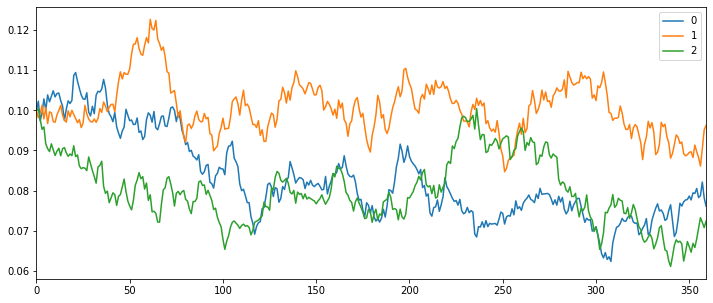

In [37]:
cir(n_years=30, n_scenarios=3, a=0.1, sigma=0.02287738471, r_0=0.10, b=0.0814).plot(figsize=(12,5))

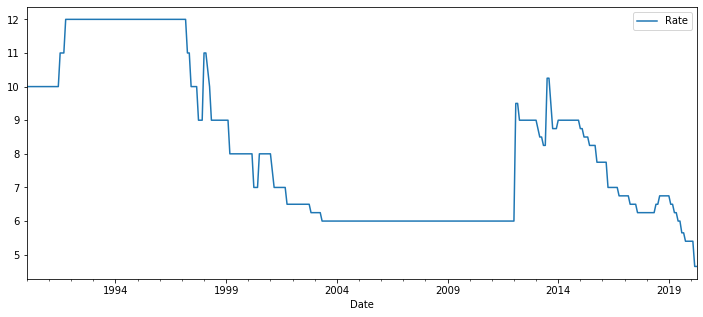

In [38]:
# INDIA REPO RATE TREND

repo = pd.read_excel(r'Data\India_Repo_Rates.xlsx', index_col=0)
repo.plot(figsize=(12,5))

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [39]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [42]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Setting $number$ $of$ $scenarios=27$ and varying all the other parameters to any value, we will find that the price of the bonds for all the scenarios will converge to 1.

However, by increasing the $sigma$ value we find that the prices can become very volatile through the duration of the bond.

In [43]:
# my starting asset value today aka cash in hand (in million)
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, sigma=0.05, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 million in 10 years
zc_0 = brat.present_value(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price (in million)
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

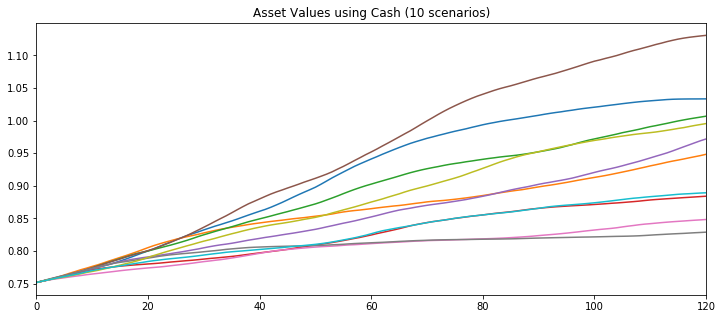

In [48]:
av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,5))

This shows that investing in cash is actually not that safe because the value of the money in 10 years will depend on interest Rate changes. Therefore, in certain scenarios we might even endup with a shortfall.

Hoever, if we invest in $zero$ $coupon$ $bonds$....

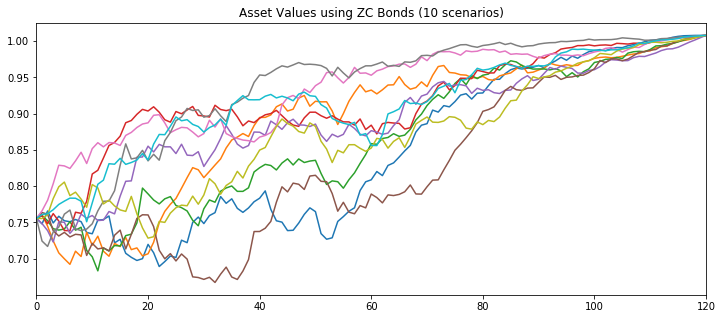

In [49]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

we see that inspite the rollercoaster ride over the 10 years, the $zero$ $coupon$ $bonds$ always allows us to meet our $Liabilities$.

If we look at hte $Funding$ $Ratios$ it paints a much clearer picture

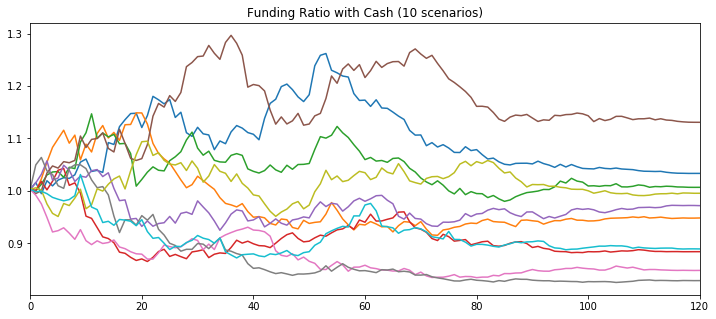

In [51]:
(av_cash/liabilities).plot(title='Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

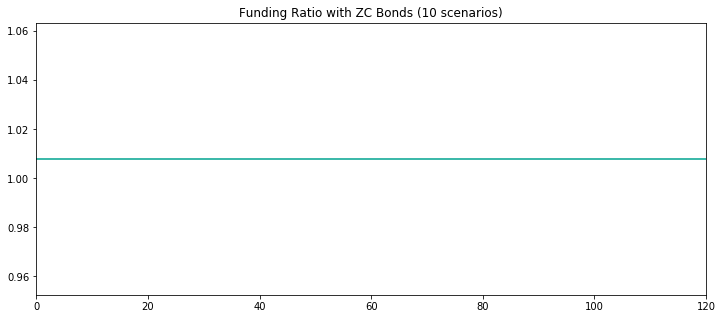

In [52]:
(av_zc_bonds/liabilities).plot(title='Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))

### Conclusion

As you can see, hedging a future liability with cash or even cash-like instruments can be very risky. Although Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, this makes two convenient assumptions that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the intial assets to be able to afford the hedge.

#### However, in reality finding the right $zero$ $coupon$ $bonds$ to meet our $liability$ $payment$ $schedule$ is not only much harder, we also need to be able to gain greater returns due to a shortage in our initial assets